In [55]:
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.trainer as trainer
import torch.utils.trainer.plugins
from torch.autograd import Variable
import numpy as np
import os

from imagedataset import ImageDataset

In [56]:
# show images inline
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def show_images(images):
    figure = plt.figure()
    i = 1
    for img in images:
        figure.add_subplot(1,len(images),i)
        plt.imshow(img)
        i += 1
# display all dataframe columns
pd.options.display.max_columns = 50

In [57]:
# train_dir = "train"
train_dir = "sample"
use_cuda = False
batch_size = 2
print('Using CUDA:', use_cuda)

Using CUDA: False


In [58]:
data_path = "data/galaxies/"

def dataframe_from_csv():
    df=pd.read_csv(data_path + "classes.csv", sep=',')
    df.set_index("GalaxyID", inplace=True)
    df=df[["Class1.1","Class1.2","Class1.3"]] ## Comment out to use all labels
    return df

Images in sample folder: 10


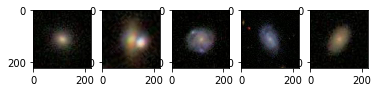

In [59]:
import importlib
import imagedataset
importlib.reload(imagedataset)

# Data loading code
traindir = os.path.join(data_path, train_dir )
valdir = os.path.join(data_path, 'valid') 
testdir = os.path.join(data_path, 'test')
sampledir = os.path.join(data_path, 'sample')

targets = dataframe_from_csv();
num_classes = len(targets.columns)

# pytorch way of implementing fastai's get_batches, (utils.py)
def get_data_loader(dirname, shuffle=True, batch_size = 64, test_mode = False):
    image_dataset = ImageDataset(dirname, targets, test_mode)
    return torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, 
                                       shuffle=shuffle, pin_memory=use_cuda), image_dataset

sample_loader, sample_dataset = get_data_loader(sampledir, batch_size=batch_size)
print('Images in sample folder:', len(sample_dataset))

# Display the first 5 images
show_images([img[0] for img in sample_dataset.images_targets[:5]])

In [60]:
train_loader, train_dataset = get_data_loader(traindir, batch_size=batch_size)
print('Images in train folder:', len(train_dataset))

Images in train folder: 10


In [61]:
targets.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100008,0.383147,0.616853,0.000000
100023,0.327001,0.663777,0.009222
100053,0.765717,0.177352,0.056931
100078,0.693377,0.238564,0.068059
100090,0.933839,0.000000,0.066161


In [62]:
# Load the model
model = models.resnet50(pretrained=True)

In [63]:
expansion = 4 # TODO use Bottleneck.expansion instead
def get_decision_tree_fc():
    branches = nn.ModuleList([
        nn.Sequential(nn.Linear(512 * expansion, 3), nn.Softmax()), # Classes: 1.1, 1.2, 1.3
        nn.Sequential(nn.Linear(512 * expansion, 2), nn.Softmax()), # Classes: 2.1, 2.2
        nn.Sequential(nn.Linear(512 * expansion, 2), nn.Softmax()), # Classes: 3.1, 3.2, 3.3
        nn.Sequential(nn.Linear(512 * expansion, 2), nn.Softmax()), # Classes: 4.1, 4.2
        nn.Sequential(nn.Linear(512 * expansion, 4), nn.Softmax()), # Classes: 5.1, 5.2, 5.3, 5.4
        nn.Sequential(nn.Linear(512 * expansion, 2), nn.Softmax()), # Classes: 6.1, 6.2
        nn.Sequential(nn.Linear(512 * expansion, 3), nn.Softmax()), # Classes: 7.1, 7.2, 7.3
        nn.Sequential(nn.Linear(512 * expansion, 7), nn.Softmax()), # Classes: 8.1, ..., 8.7
        nn.Sequential(nn.Linear(512 * expansion, 3), nn.Softmax()), # Classes: 9.1, 9.2, 9.3
        nn.Sequential(nn.Linear(512 * expansion, 3), nn.Softmax()), # Classes: 10.1, 10.2, 10.3
        nn.Sequential(nn.Linear(512 * expansion, 6), nn.Softmax()) # Classes: 11.1, ..., 11.6
    ])
    return branches

def normalize(x):
    # x is list of 11 elements, one tensor per class
    offset = -1
    # Class 1  NOP
    x[2 + offset] = torch.mm(torch.diag(x[1 + offset][:,2 + offset]), x[2 + offset]) # Class 1.2 * Class 2
    x[3 + offset] = torch.mm(torch.diag(x[2 + offset][:,2 + offset]), x[3 + offset]) # Class 2.2 * Class 3
    x[4 + offset] = torch.mm(torch.diag(x[2 + offset][:,2 + offset]), x[4 + offset]) # Class 2.2 * Class 4
    x[5 + offset] = torch.mm(torch.diag(x[2 + offset][:,2 + offset]), x[5 + offset]) # Class 2.2 * Class 5
    # Class 6  NOP
    x[7 + offset] = torch.mm(torch.diag(x[1 + offset][:,1 + offset]), x[7 + offset]) # Class 1.1 * Class 7
    x[8 + offset] = torch.mm(torch.diag(x[6 + offset][:,1 + offset]), x[8 + offset]) # Class 6.1 * Class 8
    x[9 + offset] = torch.mm(torch.diag(x[2 + offset][:,1 + offset]), x[9 + offset]) # Class 2.1 * Class 9
    x[10 + offset] = torch.mm(torch.diag(x[4 + offset][:,1 + offset]), x[10 + offset]) # Class 4.1 * Class 10
    x[11 + offset] = torch.mm(torch.diag(x[4 + offset][:,1 + offset]), x[11 + offset]) # Class 4.1 * Class 11
    return x

def get_decision_tree_fc_c1():
    branches = nn.ModuleList([
        nn.Sequential(nn.Linear(512 * expansion, 3), nn.Softmax()), # Classes: 1.1, 1.2, 1.3
    ])
    return branches

def normalize_c1(x):
    return x

In [64]:
import types

def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    
    # replace the last fc layer by a concatenation (columns = 1) of all branches defined in the resnet galaxy model
    bx = [b(x) for b in self.branches]
    return torch.cat(normalize_c1(bx), 1) ## Use Class 1 only

# Finetune by replacing the last fully connected layer and freezing all network parameters
for param in model.parameters():
    param.requires_grad = False

# The fc layer is no longer needed
if hasattr(model, 'fc'):
    del model.fc
model.branches = get_decision_tree_fc_c1()  ## Use Class 1 only

# Monkey patch Resnet's forward layer to use our own instead
model.forward = types.MethodType(forward, model) 

In [65]:
# Replace the last fully-connected layer matching the new class count
print('Using {:d} classes: {}'.format(num_classes, targets.columns))

Using 3 classes: Index(['Class1.1', 'Class1.2', 'Class1.3'], dtype='object')


In [12]:
# Or load the model if already trained
# model = torch.load("data/galaxies/resnet-50.pth")

In [66]:
# define loss function (criterion) and optimizer
criterion = nn.MSELoss()
# enable cuda if available
if(use_cuda):
    model.cuda()
    criterion.cuda()
optimizer = optim.SGD(model.branches.parameters(), lr=1e-2, momentum=0.9)

In [67]:
def getTrainer():
    # fine-tune with new classes
    t = trainer.Trainer(model, criterion, optimizer, train_loader)
    t.register_plugin(trainer.plugins.ProgressMonitor())
    t.register_plugin(trainer.plugins.LossMonitor())
    t.register_plugin(trainer.plugins.TimeMonitor())
    t.register_plugin(trainer.plugins.Logger(['progress', 'loss', 'time']))
    
    # Requires a monkey patched version of trainery.py that calls
    # input_var = Variable(batch_input.cuda())    # Line 57
    # target_var = Variable(batch_target.cuda())  # Line 58
    return t

In [68]:
t = getTrainer()
epochs = 1
model.train()
t.run(epochs)

progress: 1/5 (20.00%)	loss: 0.0797  (0.0239)	time: 0ms  (0ms)
progress: 2/5 (40.00%)	loss: 0.0791  (0.0405)	time: 597ms  (179ms)
progress: 3/5 (60.00%)	loss: 0.1041  (0.0595)	time: 591ms  (303ms)
progress: 4/5 (80.00%)	loss: 0.2458  (0.1154)	time: 592ms  (390ms)
progress: 5/5 (100.00%)	loss: 0.0599  (0.0988)	time: 595ms  (451ms)
################################################################################
Epoch summary:
loss: 0.1137	time: 475ms
################################################################################


In [16]:
# Load validation data
val_loader, val_dataset = get_data_loader(valdir, shuffle=False, batch_size=batch_size)

In [18]:
import sys

def get_error(val_loader):
    # Process each mini-batch and accumulate all correct classifications
    num_batches = sum(1 for b in enumerate(val_loader))
    batches = enumerate(val_loader)
    error2 = 0
    for i, (images, labels) in batches:
        sys.stdout.write('\rBatch: {:d}/{:d}'.format(i + 1, num_batches))
        sys.stdout.flush()
        if use_cuda:
            images = images.cuda()
        predictions = model(Variable(images, volatile=True))
        error2 += labels.sub(predictions.data.cpu()).pow(2).sum()
    # Avoid carriage return
    print('')
    return np.sqrt(error2 / len(val_loader.dataset.images_targets) / num_classes )

In [19]:
model.eval()
print('RMSE for validation set: {}'.format(get_error(train_loader)))

Batch: 5/5
RMSE for validation set: 0.27570615164277124


In [15]:
# Load test data
test_loader, test_dataset = get_data_loader(testdir, shuffle=False, batch_size=batch_size, test_mode = True)

Using test mode


In [20]:
import sys

def predict(loader):
    # Process each mini-batch and accumulate all correct classifications
    all_predictions_df = pd.DataFrame(data=None, columns=targets.columns,index=targets.index)
    # Drop all rows
    all_predictions_df.drop(targets.index, inplace=True)
    num_batches = sum(1 for b in enumerate(loader))
    batches = enumerate(loader)
    current_image = 0
    for i, (images, labels) in batches:
        sys.stdout.write('\rBatch: {:d}/{:d}'.format(i + 1, num_batches))
        sys.stdout.flush()
        if use_cuda:
            images = images.cuda()
        predictions = model(Variable(images, volatile=True))
        batch_predictions = predictions.data.cpu().numpy()
        for row_prediction in batch_predictions:
            image_id = loader.dataset.images_idx_to_id[current_image]
            all_predictions_df.loc[image_id] = row_prediction
            current_image += 1
    # Avoid carriage return
    print('')
    return all_predictions_df

def save_kaggle_predictions(loader):
    all_predictions_df = predict(loader)
    all_predictions_df.to_csv(data_path + "predicted-resnet.csv")
    return all_predictions_df

In [21]:
model.eval()
print('RMSE for sample set: {}'.format(get_error(sample_loader)))
predictions_sample_df = predict(sample_loader)
sample_ids = [121190, 172857, 411011, 447671, 504228]

Batch: 5/5
RMSE for sample set: 0.27570615164277124
Batch: 5/5


In [22]:
# Predicted
predictions_sample_df.loc[sample_ids]

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
121190,0.305208,0.576690,0.118102
172857,0.293532,0.613466,0.093002
411011,0.338271,0.550676,0.111053
447671,0.281302,0.638197,0.080501
504228,0.310797,0.591123,0.098080


In [23]:
# vs. Expected
targets.loc[sample_ids]

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
121190,0.917746,0.065081,0.017173
172857,0.236824,0.672569,0.090607
411011,0.040400,0.945151,0.014449
447671,0.016244,0.976740,0.007016
504228,0.334812,0.654743,0.010444


In [84]:
from IPython.display import FileLink
model.eval()
predictions_df = save_kaggle_predictions(train_loader)
FileLink(data_path + "predicted-resnet.csv")

Batch: 5/5


/Users/rodrigo/Libs/fastai-courses/deeplearning1/nbs/data/galaxies/predicted-resnet.csv

In [85]:
predictions_df.loc[[121190]]

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
GalaxyID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
121190,0.370342,0.303781,0.325876,0.159851,0.14393,0.096677,0.047253,0.030769,0.113161,0.035853,0.036615,0.042174,0.029288,0.448526,0.551474,0.116921,0.140765,0.112656,0.061869,0.084487,0.06544,0.052355,0.038448,0.07991,0.066018,0.051639,0.035258,0.072954,0.014407,0.010246,0.006115,0.004381,0.005554,0.005709,0.004226,0.005747,0.005151


In [30]:
# Save model
torch.save(model, "data/galaxies/resnet-50.pth")